# 割引クーポンキャンペーンの効果最大化

## 導入

- マーケティング施策
    - 目的：割引クーポンを同封したダイレクトメールを会員へ送付する｢割引クーポンキャンペーン｣でより多くの会員へ店舗へ来店してもらう
    - やること：予算と送付率の制約の元で，来客数を最大にするようなDMの送付方法を決定する

- 全会員に以下の3パターンのいずれかのDMを送信
    - セールのチラシのみ
    - セールのチラシと1000円のクーポン
    - セールのチラシと2000円のクーポン
- 制約
    - 各パターンのDMを類似した来店傾向の会員をグループ化したセグメントごとに10％送付する
        - 次回以降の割引クーポンキャンペーンで利用する来店率のデータを一定数取得するため
    - 予算は100万円
        - 正確には予算の消費期待値
        - クーポンを送付しても利用するかはわからないため(利用されないクーポンは予算には含まれない)

## 課題整理

- 数理モデルによる決定事項
    - 各会員に対してどのパターンのダイレクトメール(DM)を送付するかを決定
- 送付するダイレクトメールの数
    - 各会員に対して送付するDMは以下のいずれかの1パターン
        - セールのチラシのみ
        - セールのチラシと1000円のクーポン
        - セールのチラシと2000円のクーポン
- キャンペーンの目的
    - クーポン送付による来客数を最大化する
- キャンペーン予算
    - 会員の予算消費期待値の合計は100万円以下
- 次回以降のクーポンキャンペーンで利用する来店率の収集
    - 各パターンのDMをそれぞれのセグメントに属する会員10％以上に送付

## データ理解

In [4]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pulp

%matplotlib inline

In [2]:
# 会員データ
df_customer = pd.read_csv('data/4.coupon/customers.csv')
print(df_customer.shape)
df_customer.head()

(5000, 3)


,customer_id,age_cat,freq_cat
0,1,age20~34,freq2
1,2,age35~49,freq0
2,3,age35~49,freq0
3,4,age~19,freq0
4,5,age35~49,freq0


- `customer_id` : 1~5,000の間でユニークな整数値をとる
- `age_cat` : 年齢区分
- `freq_cat` : 昨年度来店回数区分

In [12]:
# 年齢区分の分布
df_customer.groupby('age_cat').agg({'customer_id': 'nunique'})

,customer_id
age_cat,
age20~34,1500
age35~49,2000
age50~,1000
age~19,500


In [13]:
# 昨年来店回数区分の分布
df_customer.groupby('freq_cat').agg({'customer_id': 'nunique'})

,customer_id
freq_cat,
freq0,2000
freq1,1500
freq2,500
freq3~,1000


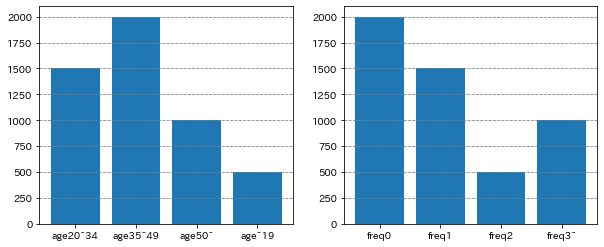

In [58]:
# 可視化
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
d1 = df_customer.groupby('age_cat')['customer_id'].count()
d2 = df_customer.groupby('freq_cat')['customer_id'].count()
axes[0].bar(d1.index, d1.values)
axes[1].bar(d2.index, d2.values)
axes[0].grid(axis='y', ls='--', color='gray')
axes[1].grid(axis='y', ls='--', color='gray', )
fig.show()

In [21]:
# クロス集計
df_pivot_customer = pd.pivot_table(
    data=df_customer,
    values='customer_id',
    columns='freq_cat',
    index='age_cat',
    aggfunc='count')
df_pivot_customer

freq_cat,freq0,freq1,freq2,freq3~
age_cat,,,,
age20~34,600,450,150,300
age35~49,800,600,200,400
age50~,400,300,100,200
age~19,200,150,50,100


<AxesSubplot:xlabel='freq_cat', ylabel='age_cat'>

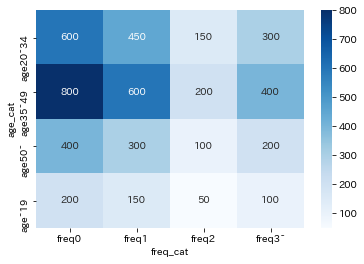

In [23]:
# 可視化
sns.heatmap(df_pivot_customer, annot=True, fmt='d', cmap='Blues')

In [7]:
# 来店率データ
df_proba = pd.read_csv('data/4.coupon/visit_probability.csv')
print(df_proba.shape)
df_proba

(16, 6)


,age_cat,freq_cat,segment_id,prob_dm1,prob_dm2,prob_dm3
0,age~19,freq0,1,0.07,0.12,0.29
1,age~19,freq1,2,0.21,0.30,0.58
2,age~19,freq2,3,0.28,0.39,0.74
3,age~19,freq3~,4,0.35,0.45,0.77
4,age20~34,freq0,5,0.11,0.17,0.37
5,age20~34,freq1,6,0.32,0.43,0.72
6,age20~34,freq2,7,0.42,0.55,0.93
7,age20~34,freq3~,8,0.52,0.63,0.94
8,age35~49,freq0,9,0.08,0.14,0.33
9,age35~49,freq1,10,0.25,0.35,0.67


- `age_cat` : 年齢区分
- `freq_cat` : 昨年度来店回数区分
- `segment_id` : セグメントID．年齢区分と昨年度来店回数区分の組み合わせによる会員のセグメント
- `prob_dm1` : パターン1来店率．当該セグメントにセールのチラシのみのDMを送付したときの来店率
- `prob_dm2` : パターン2来店率．セールチラシと1,000円のクーポンのDMを送付したときの来店率
- `prob_dm3` : パターン3来店率．セールチラシと2,000円のクーポンのDMを送付したときの来店率

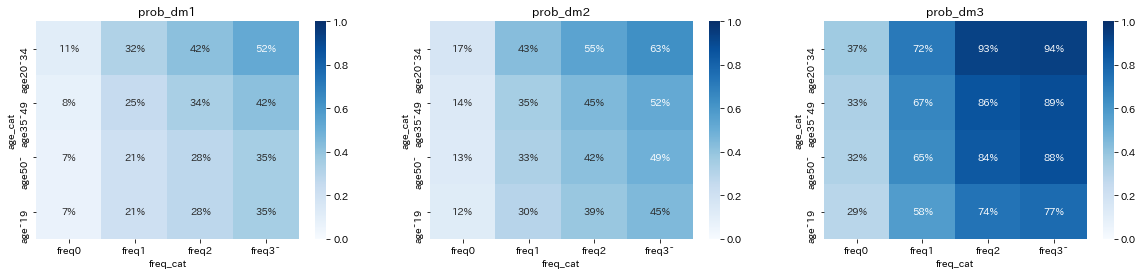

In [46]:
# 各DM送付パターンの来店率をクロス集計
fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(20,4))
for dm_ptn, ax in zip(['prob_dm1','prob_dm2','prob_dm3'], axes):
    df_piv = pd.pivot_table(
        data=df_proba,
        values=dm_ptn,
        columns='freq_cat',
        index='age_cat')
    sns.heatmap(df_piv, vmin=0, vmax=1, annot=True, fmt='.0%', cmap='Blues', ax=ax)
    ax.set_title(dm_ptn)
fig.show()

## モデリング 